In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import datetime
import csv
import math
import time
from ProgressBar import ProgressBar

import nltk
import string
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

/Users/kshain/anaconda/envs/AC209/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [414]:
data = pd.read_csv('2004_Output.csv', header=None)
data.columns = ['id','date','headline', 'lead']
data.head()

,id,date,headline,lead
0,4fd24bbc8eb7c8105d7eafa0,2004-01-08T00:00:00Z,COMPANY BRIEFS,"Great Atlantic & Pacific Tea Co., Montvale, N...."
1,4fd23a1e8eb7c8105d7ce71a,2004-01-08T00:00:00Z,How to Grow Without a Lot of Capital,David Hartstein wanted to make his KaBloom cha...
2,4fd23c148eb7c8105d7d1641,2004-01-08T00:00:00Z,"Trials, Trials, Trials, and Then What?",With the trials of iconic corporate executives...
3,4fd23c148eb7c8105d7d164a,2004-01-08T00:00:00Z,"Economic Scene; After 40 years, what are some ...","''THIS administration today, here and now, dec..."
4,4fd27aa38eb7c8105d83f1d1,2004-01-08T00:00:00Z,Technology Briefing | Software: Veritas To Buy...,The Veritas Software Corporation plans to expa...


In [437]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [463]:
def getLemmatized(lead):
    tokens = nltk.word_tokenize(''.join(ch for ch in lead if ch not in set(string.punctuation)))
    tags = nltk.pos_tag(tokens)
    tags = map(lambda x: x[1], tags)
    lemmaTags = map(get_wordnet_pos, tags)
    wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
    return map(lambda x: wordnet_lemmatizer.lemmatize(x[0].decode('utf-8'), x[1]), zip(tokens, lemmaTags))

In [465]:
data['leadLemmas'] = map(getLemmatized, data.lead)

In [466]:
data.head()

,id,date,headline,lead,leadLemmas
0,4fd24bbc8eb7c8105d7eafa0,2004-01-08T00:00:00Z,COMPANY BRIEFS,"Great Atlantic & Pacific Tea Co., Montvale, N....","[Great, Atlantic, Pacific, Tea, Co, Montvale, ..."
1,4fd23a1e8eb7c8105d7ce71a,2004-01-08T00:00:00Z,How to Grow Without a Lot of Capital,David Hartstein wanted to make his KaBloom cha...,"[David, Hartstein, want, to, make, his, KaBloo..."
2,4fd23c148eb7c8105d7d1641,2004-01-08T00:00:00Z,"Trials, Trials, Trials, and Then What?",With the trials of iconic corporate executives...,"[With, the, trial, of, iconic, corporate, exec..."
3,4fd23c148eb7c8105d7d164a,2004-01-08T00:00:00Z,"Economic Scene; After 40 years, what are some ...","''THIS administration today, here and now, dec...","[THIS, administration, today, here, and, now, ..."
4,4fd27aa38eb7c8105d83f1d1,2004-01-08T00:00:00Z,Technology Briefing | Software: Veritas To Buy...,The Veritas Software Corporation plans to expa...,"[The, Veritas, Software, Corporation, plan, to..."


In [2]:
all_data_list = []
for year in range(2000,2007):
    data = pd.read_csv('{}_Output.csv'.format(year), header=None)
    all_data_list.append(data) # list of dataframes
data = pd.concat(all_data_list, axis=0)
data.columns = ['id','date','headline', 'lead']

In [470]:
data['yearmonth'] = map(lambda x: x[:7], data.date)

In [3]:
def getStems(lead):
    stemmer = nltk.stem.SnowballStemmer("english")
    tokens = nltk.word_tokenize(''.join(ch for ch in lead if ch not in set(string.punctuation)))
    return map(lambda x: stemmer.stem(x.decode('utf-8')), tokens)

In [4]:
def joinstems(stemlist):
    return ' '.join(stem for stem in stemlist)

In [5]:
stems = map(getStems, data.lead)

In [6]:
data['leadstems'] = map(joinstems, stems)

In [211]:
def getBigrams(stems):
    finder = nltk.collocations.BigramCollocationFinder.from_words(stems)
    return(finder.ngram_fd.items())

In [212]:
bigramList = map(getBigrams, stems)

In [213]:
flatBigrams = [item for sublist in bigramList for item in sublist]

In [214]:
def reduceByKey(toIterate):
    d = defaultdict(int)
    for i, (key, value) in enumerate(toIterate):
        d[key] += value
    return list(d.items())

In [215]:
len(flatBigrams)

9917550

In [216]:
summedBigrams = reduceByKey(flatBigrams)

In [217]:
def xLogX(x):
    if x==0:
        return 0
    else:
        return x * np.log(x)
    
def entropy(things):
    theSum = 0
    theResult = 0
    for thing in things:
        theResult += xLogX(thing)
        theSum += thing;

    return xLogX(theSum) - theResult;

def logLikelihoodRatio(k11, k12, k21, k22):
    rowEntropy = entropy([k11 + k12, k21 + k22]);
    columnEntropy = entropy([k11 + k21, k12 + k22]);
    matrixEntropy = entropy([k11, k12, k21, k22]);
    return(2.0 * (rowEntropy + columnEntropy - matrixEntropy))

def getLLR(summedBigram):
    k11 = summedBigram[1]
    stem1 = summedBigram[0][0]
    stem2 = summedBigram[0][1]
    k12 = bigrams1Dict[stem1] - k11
    k21 = bigrams2Dict[stem2] - k11
    k22 = totalBigrams - k11 - k12 - k21
    return(logLikelihoodRatio(k11, k12, k21, k22))

In [218]:
bigrams1 = map(lambda x: (x[0][0], x[1]), summedBigrams)
summedBigrams1= reduceByKey(bigrams1)

In [219]:
bigrams2 = map(lambda x: (x[0][1], x[1]), summedBigrams)
summedBigrams2= reduceByKey(bigrams2)

In [220]:
bigrams1Dict = dict(summedBigrams1)
bigrams2Dict = dict(summedBigrams2)

In [221]:
onlyValues = np.array(map(lambda x: x[1], summedBigrams))
totalBigrams = onlyValues.sum()

In [222]:
LLRs = map(getLLR, summedBigrams)

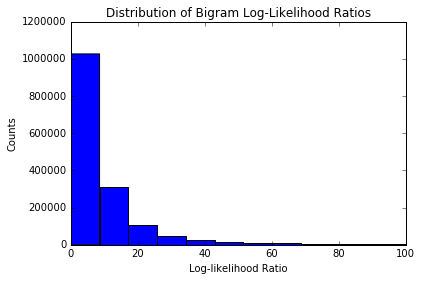

In [223]:
plt.hist(LLRs, bins=20000);
plt.xlim((0,100))
plt.xlabel('Log-likelihood Ratio')
plt.ylabel('Counts')
plt.title('Distribution of Bigram Log-Likelihood Ratios')

In [273]:
bigramVocab = np.array(summedBigrams)[list(np.where(np.array(LLRs)>500)[0])]

In [274]:
np.array(summedBigrams)[np.argmax(np.array(LLRs))]

array([(u'new', u'york'), 14885], dtype=object)

In [322]:
len(bigramVocab)

6463

In [320]:
stopwords = ['the','a','an','and','it','this','that','he','I','she','of','is']

In [321]:
bigramVocab = [bigram for bigram in bigramVocab if (set(bigram[0]).isdisjoint(stopwords))]

In [329]:
bigramVocab[1900]

array([(u'feder', u'regul'), 636], dtype=object)

In [236]:
np.array(bigramVocab)[np.argmax(np.array(map(lambda x: x[1], bigramVocab)))]

array([(u'of', u'the'), 65772], dtype=object)

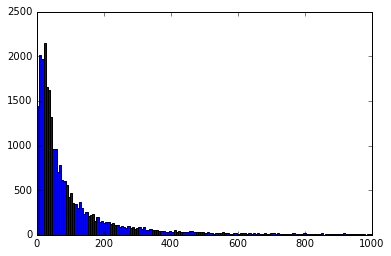

In [237]:
plt.hist(map(lambda x: x[1], bigramVocab), bins=10000);
plt.xlim((0,1000));

In [361]:
bigramVocab = map(lambda x: x[0][0]+' '+x[0][1], list(bigramVocab))

In [239]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
analyzer = CountVectorizer().build_analyzer()

def stem_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [395]:
countVec = CountVectorizer(stop_words='english', max_df=0.8, min_df=.005, strip_accents='unicode')
wordMatrix = countVec.fit_transform(data.leadstems)
unigramVocab = countVec.get_feature_names()

In [396]:
totalVocab = unigramVocab + bigramVocab

In [397]:
len(unigramVocab)

1407

In [398]:
len(bigramVocab)

6463

In [399]:
len(totalVocab)

7870

In [400]:
countVecAll = CountVectorizer(ngram_range = (1,2), vocabulary = totalVocab)
wordMatrix = countVecAll.fit_transform(data.leadstems)

In [401]:
np.sum(wordMatrix)

6474051

In [402]:
wordMatrix.shape

(126110, 7870)

In [403]:
grouped = data.groupby('yearmonth')

In [404]:
wordsByMonth = np.zeros((len(grouped.groups.keys()),wordMatrix.shape[1]))
for i, month in enumerate(np.sort(grouped.groups.keys())):
    wordsByMonth[i] = np.sum(wordMatrix[grouped.get_group(month).index], axis=0)

In [405]:
wordsByMonth.shape

(84, 7870)

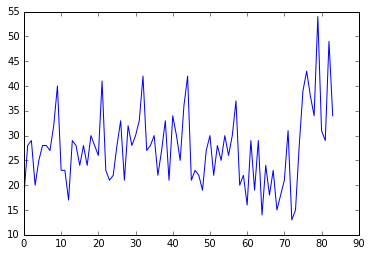

In [406]:
plt.plot(wordsByMonth[:,150])

In [407]:
float(np.sum(wordsByMonth==0))/(wordsByMonth.shape[0]*wordsByMonth.shape[1])

0.30542596962546137

In [408]:
countVecAll.get_feature_names()[150]

u'appear'

In [409]:
totalVocab

[u'10',
 u'100',
 u'1000',
 u'10yr',
 u'11',
 u'12',
 u'125',
 u'13',
 u'14',
 u'15',
 u'150',
 u'16',
 u'17',
 u'175',
 u'18',
 u'19',
 u'1990s',
 u'1996',
 u'1997',
 u'1998',
 u'1999',
 u'20',
 u'200',
 u'2000',
 u'2001',
 u'2002',
 u'2003',
 u'2004',
 u'2005',
 u'2006',
 u'21',
 u'22',
 u'23',
 u'24',
 u'25',
 u'250',
 u'26',
 u'27',
 u'28',
 u'29',
 u'30',
 u'300',
 u'30yr',
 u'31',
 u'32',
 u'33',
 u'34',
 u'35',
 u'36',
 u'37',
 u'38',
 u'39',
 u'3month',
 u'40',
 u'400',
 u'41',
 u'42',
 u'425',
 u'43',
 u'44',
 u'45',
 u'450',
 u'46',
 u'47',
 u'475',
 u'48',
 u'49',
 u'50',
 u'500',
 u'500stock',
 u'51',
 u'52',
 u'53',
 u'54',
 u'55',
 u'56',
 u'57',
 u'58',
 u'60',
 u'600',
 u'65',
 u'6month',
 u'70',
 u'75',
 u'80',
 u'85',
 u'90',
 u'a1',
 u'abil',
 u'abl',
 u'abov',
 u'acceler',
 u'accept',
 u'access',
 u'accord',
 u'account',
 u'accus',
 u'acknowledg',
 u'acquir',
 u'acquisit',
 u'act',
 u'action',
 u'activ',
 u'actual',
 u'ad',
 u'add',
 u'addit',
 u'address',
 u'adjust

In [475]:
tfidfAll = TfidfVectorizer(ngram_range = (1,2), vocabulary = totalVocab)
wordMatrixTfidf = tfidfAll.fit_transform(data.leadstems)

In [476]:
tfidfByMonth = np.zeros((len(grouped.groups.keys()),wordMatrixTfidf.shape[1]))
for i, month in enumerate(np.sort(grouped.groups.keys())):
    tfidfByMonth[i] = np.sum(wordMatrixTfidf[grouped.get_group(month).index], axis=0)

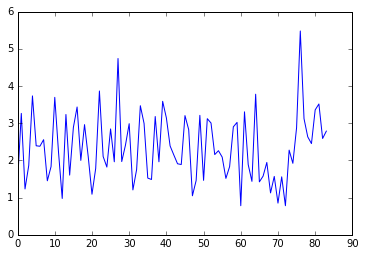

In [486]:
plt.plot(tfidfByMonth[:,1101])

In [487]:
countVecAll.get_feature_names()[1101]

u'royal'